<h1> 태화강 수위예측 프로그램 </h1>

<hr> <h2> 라이브러리 선언 </h2>

In [1]:
!pip install -r requirements.txt

  Using cached tensorflow-2.11.1-cp39-cp39-win_amd64.whl (1.9 kB)
  Using cached xgboost-1.7.4-py3-none-win_amd64.whl (89.1 MB)
  Using cached DateTime-5.1-py3-none-any.whl (52 kB)
  Using cached missingno-0.5.2-py3-none-any.whl (8.7 kB)
  Using cached tensorflow_intel-2.11.1-cp39-cp39-win_amd64.whl (266.3 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)
  Using cached protobuf-3.19.6-cp39-cp39-win_amd64.whl (895 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached flatbuffers-23.3.3-py2.py3-none-any.whl (26 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp39-cp39-win_amd64.whl (1.5 MB)
  Using cached grpcio-1.51.3-cp39-cp39-win_amd64.whl (3.7 MB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)

In [19]:
import os
import tensorflow as tf
import tensorflow.keras.callbacks as callbacks
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
plt.rc('font', family='Malgun Gothic')
%matplotlib inline
# import warnings
# warnings.filterwarnings("ignore")
# tf.set_random_seed(777)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from datetime import datetime

import missingno as msno

<hr> <h2> System Config </h2>

<h3> 데이터 전처리 변수 </h3>

In [3]:
start_time = pd.to_datetime('2016-05-01 00:00:00')
end_time = pd.to_datetime('2020-12-31 23:00:00')

daeam = ['set_date', '대암댐 수위', '대암댐 발전방류', '대암댐 여수로방류', '대암교 수위']
sayeon = ['set_date', '사연댐', '조동', '대암교 수위', '사연교']
guyoung = ['set_date', '사연댐', '사연교', '국_구영 (구영교)']
samho = ['set_date','조동', '국_삼호 (삼호교)']
taewha = ['set_date', '울산', '국_삼호 (삼호교)', 'tlevel', '국_울산 (태화교)']

<h3> 학습 변수 </h3>

In [4]:
trainSize_rate = 0.8  # 학습 및 예측 셋 구분
current_time = datetime.today().strftime("%Y%m%d_%H%M%S")

seqLength = 6  # window size
hiddenDim = 10  # hiddenUnit 수
outputDim = 1  # output
lr = 0.0001  # 학습률
drop_rate = 0.3  # Layer를 통과하여 생성된 파라메터의 수를 조정해주는 비율
target = 2  # 예측할 시간(0: 1시간, 2: 3시간, 5: 6시간)

<h3> 모델 변수 </h3>

In [5]:
model_list = ["GBM", "RF"]   # 분석 모델 리스트 설정 : LSTM, GBM, RF
performance_list = ["RMSE", "R2", "MSE"]    # 분석 성능평가 리스트 설정 : RMSE, R2, MSE, MAE

temp_list_name = ["daeam", "sayeon", "guyoung", "samho", "taewha"]

# callsback 설정
# Early Stopping, ModelCheckpoint 설정
# Early Stopping : 모델의 학습이 더이상 진전이 없으면 학습을 종료
# ModelCheckpoint : 모델 학습 중 학습이 잘되어진 모델을 계속해서 저장
cbs = [callbacks.EarlyStopping(monitor='val_loss',
                               patience=10,
                               mode='min'),
       callbacks.ModelCheckpoint(filepath='bestModel.h5',
                                 monitor='val_loss',
                                 mode='min',
                                 save_best_only=True)]

<h2> 함수 선언 </h2>

In [6]:
# Date 형 변환
def set_date(rawframe):
    rawframe['set_date'] = pd.to_datetime(rawframe[rawframe.columns[0]], format='%Y%m%d %H:%M', errors='coerce')
    rawframe = rawframe.drop(rawframe.columns[0], axis=1)
    return rawframe

# DataFrame merge
def set_merge(tb1, tb2):
    raw_return = pd.merge(tb1, tb2, how='outer', on='set_date')
    return raw_return

# 데이터 결측 범위 지정 결측값 도출
def set_outlier(df1):
    columns = list(range(1, df1.shape[1]))
    for i in columns:
        df1[df1.columns[i]].mask(
            (df1[df1.columns[i]] >= 999) | (df1[df1.columns[i]] < 0), inplace=True)
    return df1

# 입출력 자료 통합차트
def total_chart(df1, list1):
    columns = list(range(1, len(list1)))
    i = 1
    values = df1.values
    plt.figure(figsize=(9, 40))
    for variable in columns:
        plt.subplot(len(columns), 1, i)
        plt.plot(values[:, variable])
        plt.title(df1.columns[variable], y=0.5, loc='right')
        i += 1
    plt.show()

#  기본 차트 : 이미지 저장용
def basic_chart(obsY, preY, str_part):
    if str_part == 'line':
        plt.figure()
        plt.plot(range(len(obsY)), obsY, '-', label="Original Y")
        plt.plot(range(len(preY)), preY, '-x', label="predict Y")
    plt.legend(loc='upper right')

# RandomForest Regression Algorithm
def AL_RandomForest(trainX, trainY, testX, testY):
    rf_clf = RandomForestRegressor(n_estimators=100, random_state=15)
    rf_clf.fit(trainX, np.ravel(trainY, order="C"))

    # relation_square = rf_clf.score(trainX, trainY)
    # print('RandomForest 학습 결정계수 : ', relation_square)

    y_pred1 = rf_clf.predict(trainX)
    y_pred2 = rf_clf.predict(testX)

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.plot(range(len(testY)), testY, '-', label="Original Y")
    # ax.plot(range(len(y_pred2)), y_pred2, '-x', label="predict Y")
    # plt.legend(loc='upper right')
    # plt.show()

    return y_pred2

# GBR(GradientBoostingRegression) Algorithm
def AL_GradientBoosting(trainX, trainY, testX, testY):

    trainX.columns = pd.RangeIndex(trainX.shape[1])
    testX.columns = pd.RangeIndex(testX.shape[1])

    gbr_model = GradientBoostingRegressor(n_estimators=100, max_depth=3)
    gbr_model.fit(trainX, np.ravel(trainY, order="C"))

    y_pred = gbr_model.predict(trainX)
    y_pred2 = gbr_model.predict(testX)

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.plot(range(len(testY)), testY, '-', label="Original Y")
    # ax.plot(range(len(y_pred2)), y_pred2, '-x', label="predict Y")
    # plt.legend(loc='upper right')
    # plt.show()

    return y_pred2

# XGBoosting Algorithm
def AL_XGBoosting(trainX, trainY, testX, testY):

    trainX.columns = pd.RangeIndex(trainX.shape[1])
    testX.columns = pd.RangeIndex(testX.shape[1])

    xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, max_depth=3)
    xgb_model.fit(trainX, np.ravel(trainY, order="C"))

    y_pred = xgb_model.predict(trainX)
    y_pred2 = xgb_model.predict(testX)

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.plot(range(len(testY)), testY, '-', label="Original Y")
    # ax.plot(range(len(y_pred2)), y_pred2, '-x', label="predict Y")
    # plt.legend(loc='upper right')
    # plt.show()

    return y_pred2

# LSTM Algorithm
def AL_LSTM(trainX, trainY, testX, testY):
    # 모델 트레이닝
    model = keras.Sequential()
    # , activation='tanh'
    model.add(tf.keras.layers.Bidirectional(layers.LSTM(hiddenDim, return_sequences=True),
                                            input_shape=[seqLength, dataDim]))
    model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(tf.keras.layers.Bidirectional(layers.LSTM(10)))
    model.add(layers.Dense(1))

    # optimizer 설정
    opt = optimizers.Adam(lr=lr)

    # 모델 학습과정 설정
    model.compile(loss='mse', optimizer=opt, metrics=['mae'])

    # 모델 학습습
    his = model.fit(trainX, trainY, epochs=100, batch_size=16, verbose=2,
                    validation_split=0.2,
                    callbacks=cbs)

    # 모델 테스트
    y_pred = model.predict(trainX)
    y_pred2 = model.predict(testX)

    return y_pred2

# 알고리즘 실행 성능지표 함수
def Performance_index(obs, pre, mod_str):
    if mod_str == 'R2':
        pf_index = r2_score(obs, pre)
    elif mod_str == 'RMSE':
        s1 =  mean_squared_error(obs, pre)
        pf_index = np.sqrt(s1)
    elif mod_str == 'MSE':
        pf_index = mean_squared_error(obs, pre)
    elif mod_str == 'MAE':
        pf_index = mean_absolute_error(obs, pre)

    return pf_index


# 정규화 함수
def MinMaxScaler(data):
    denom = np.max(data, 0) - np.min(data, 0)
    nume = data - np.min(data, 0)
    return nume / denom


# 정규화 되돌리기 함수
def back_MinMax(data, value):
    diff = np.max(data, 0) - np.min(data, 0)
    back = value * diff + np.min(data, 0)
    return back


# 각 지점의 알맞는 학습 배치 데이터 생성 함수
def buildDataSet(timeSeries, seqLength, target):
    xdata = []
    ydata = []
    for i in range(0, len(timeSeries) - seqLength - target):
        tx = timeSeries[i:i + seqLength]
        # print(tx)
        ty = timeSeries.iloc[i + seqLength + target, -1]
        # print(ty)
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)


# 각 지점의 알맞는 학습 배치 데이터 생성 함수
def buildDataSet2(timeSeries, seqLength, target):
    xdata = pd.DataFrame()
    # ydata = pd.DataFrame()
    for s in range(0, seqLength):
        tx = timeSeries.iloc[(seqLength - s):(len(timeSeries) - s - target), :].reset_index()
        xdata = pd.concat([xdata, tx], axis=1, ignore_index=False)

    xdata = xdata.drop(['index'], axis='columns')
    ydata = pd.DataFrame(timeSeries.iloc[seqLength + target:, -1])
    return xdata, ydata

def makeDir(model):
    path_result_data = "./result_data/" + current_time + "/" + model + "/"
    if not os.path.isdir(path_result_data):
        os.makedirs(path_result_data)
    path_result_graph = "./result_graph/" + current_time + "/" + model + "/"
    if not os.path.isdir(path_result_graph):
        os.makedirs(path_result_graph)
    path_result_model = "./result_model/" + current_time + "/" + model + "/"
    if not os.path.isdir(path_result_model):
        os.makedirs(path_result_model)

    path_list = pd.DataFrame([(path_result_data, path_result_graph, path_result_model)], columns=['data','graph','model'])
    return path_list

<hr> <h2> 데이터 전처리 </h2>

<h3> 데이터 불러오기 </h3>

In [7]:
# 추후 3개의 csv로 적용
raw_flood1 = pd.read_csv('./data/flood.csv', sep=',', encoding='CP949')
raw_flood1 = set_date(raw_flood1)

raw_flood2 = pd.read_csv('./data/taehwa.csv', sep=',', encoding='CP949')
raw_flood2 = set_date(raw_flood2)

raw_rainfall = pd.read_csv('./data/rainfall.csv', sep=',', encoding='CP949')
raw_rainfall = set_date(raw_rainfall)

raw_tidal = pd.read_csv('./data/tidal.csv', sep=',', encoding='CP949')
raw_tidal = set_date(raw_tidal)

raw_timeset = pd.DataFrame(pd.date_range(start_time, end_time, freq='H'))
raw_timeset.columns = ['set_date']

<h3> 데이터 가공 </h3>

In [8]:
raw_total = set_merge(raw_timeset, raw_flood1)
raw_total = set_merge(raw_total, raw_flood2)
raw_total = set_merge(raw_total, raw_rainfall)
raw_total = set_merge(raw_total, raw_tidal)

temp_daeam = pd.DataFrame(raw_total, columns=daeam)
temp_sayeon = pd.DataFrame(raw_total, columns=sayeon)
temp_guyoung = pd.DataFrame(raw_total, columns=guyoung)
temp_samho = pd.DataFrame(raw_total, columns=samho)
temp_taewha = pd.DataFrame(raw_total, columns=taewha)

temp_daeam = set_outlier(temp_daeam)
temp_sayeon = set_outlier(temp_sayeon)
temp_guyoung = set_outlier(temp_guyoung)
temp_samho = set_outlier(temp_samho)
temp_taewha = set_outlier(temp_taewha)

<h3> 데이터 확인 </h3>

C:\Users\kwater\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kwater\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


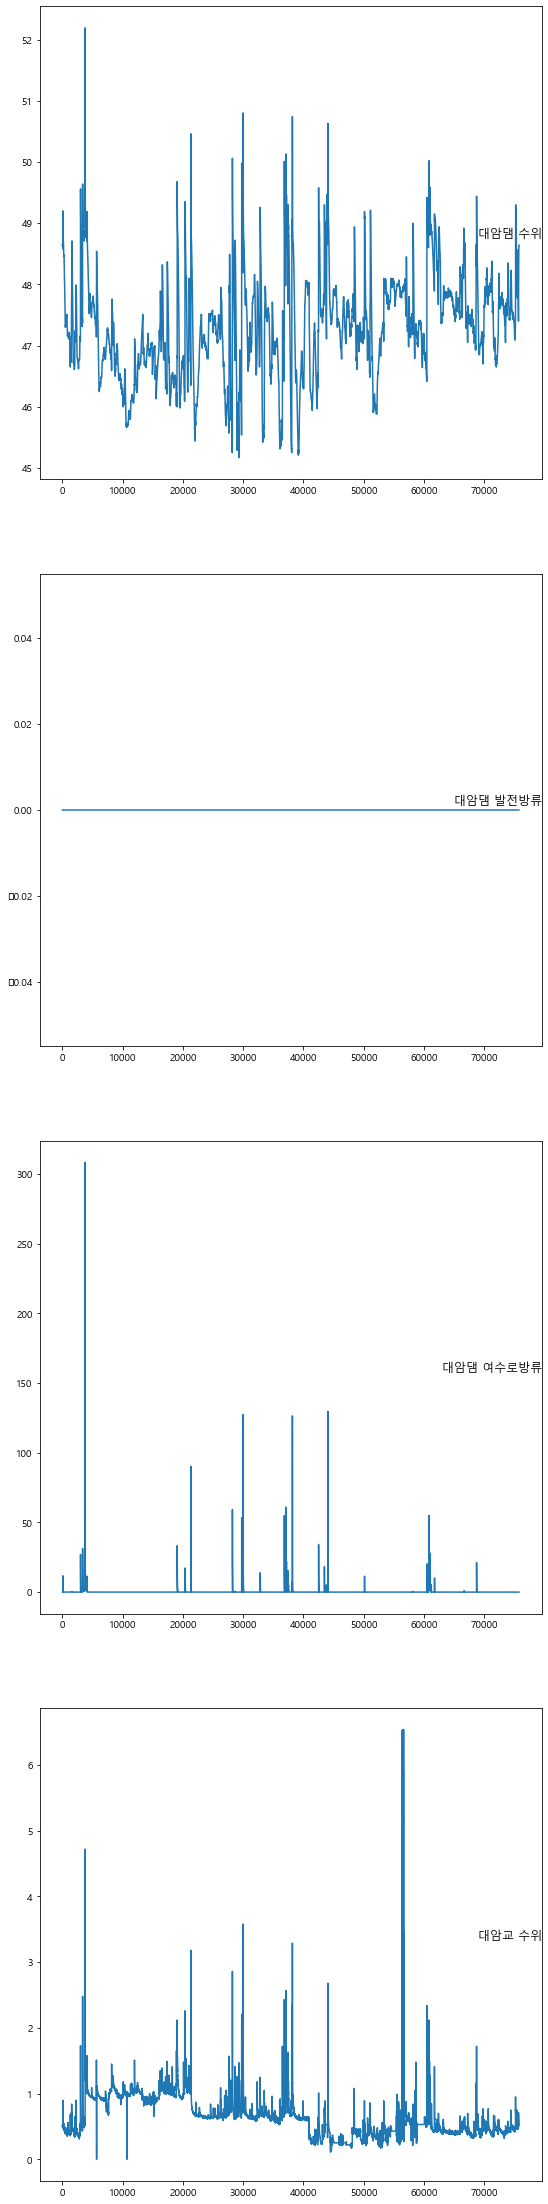

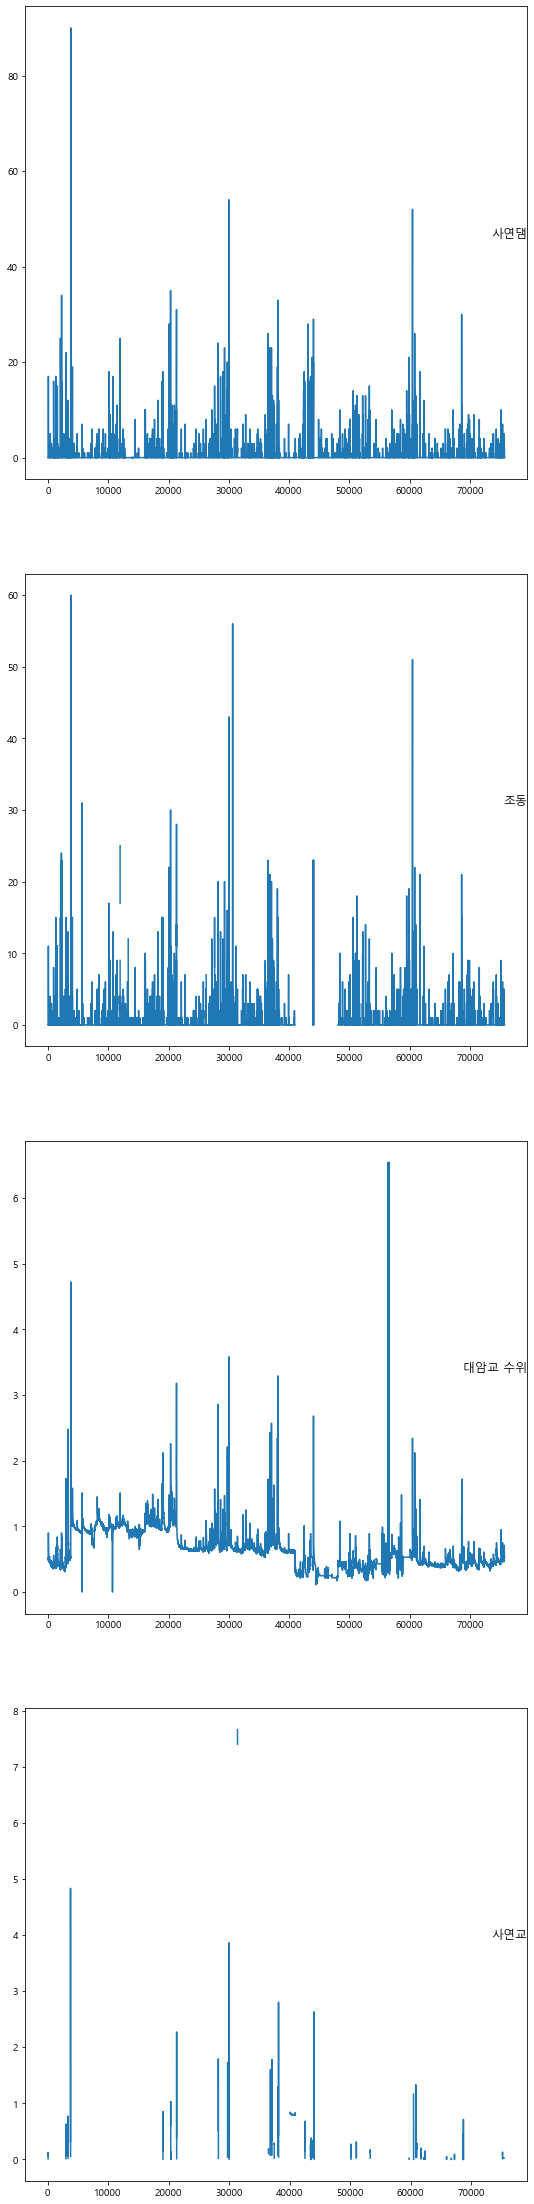

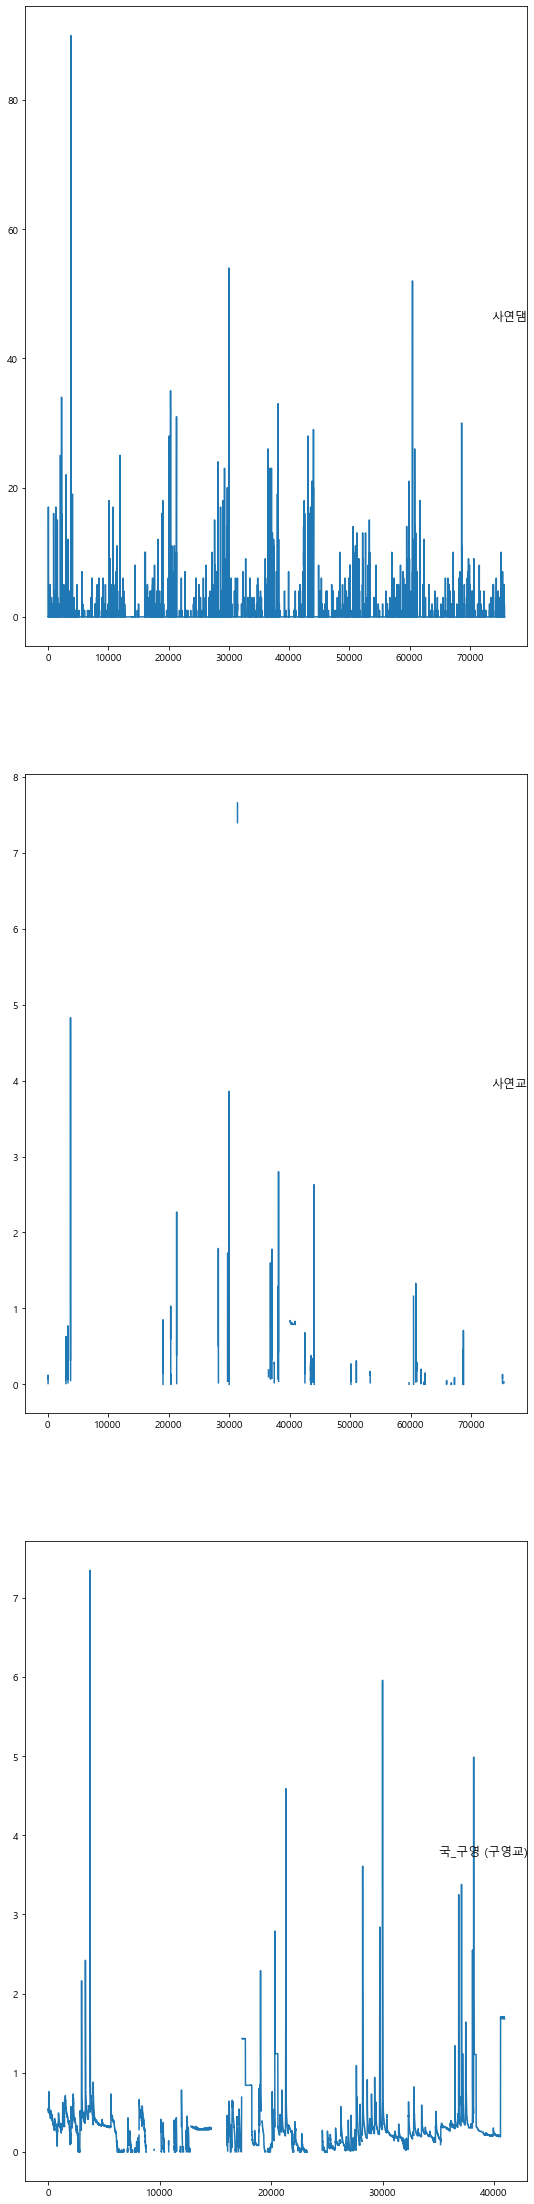

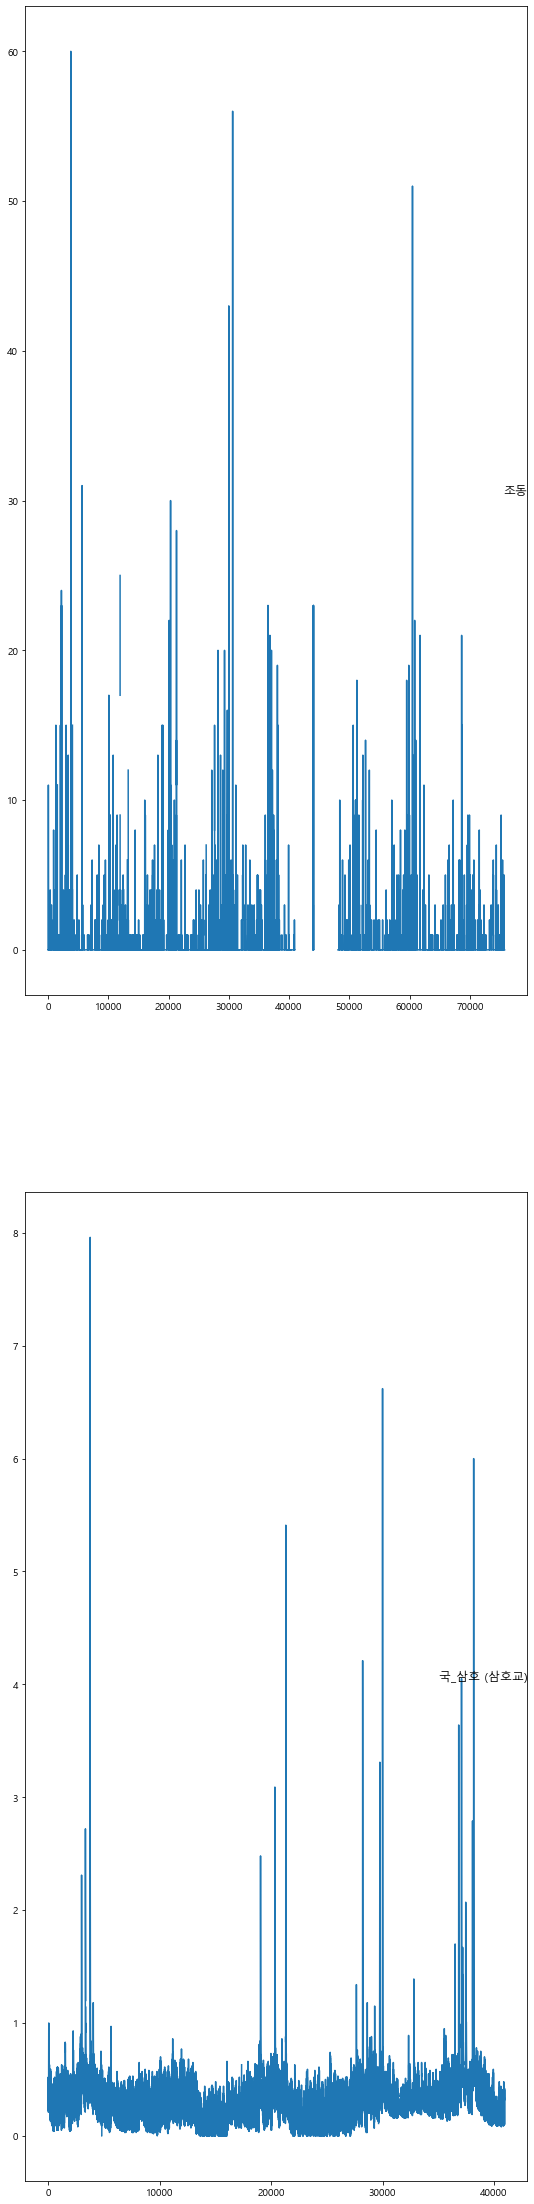

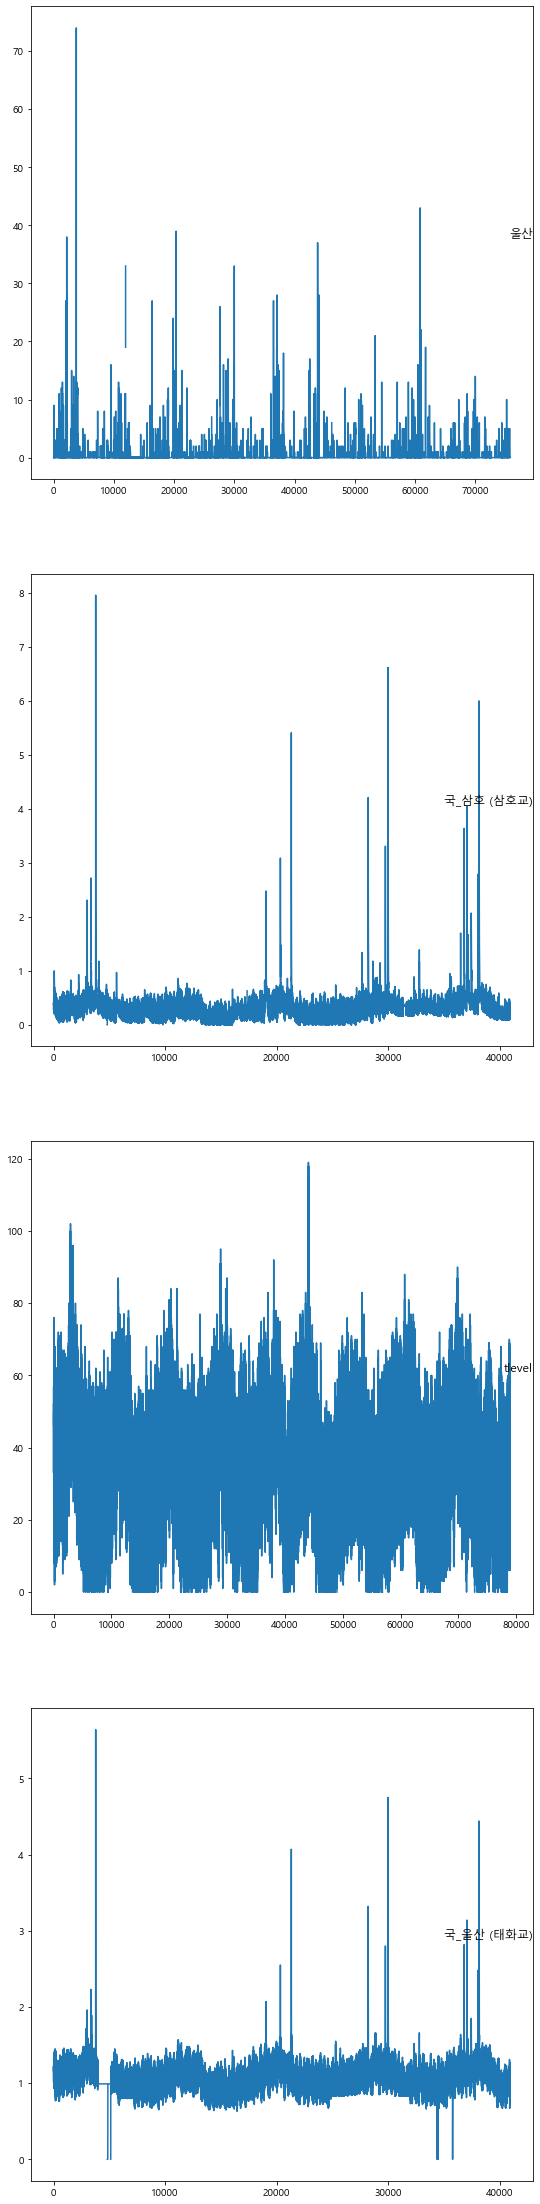

In [18]:
total_chart(temp_daeam, daeam)
total_chart(temp_sayeon, sayeon)
total_chart(temp_guyoung, guyoung)
total_chart(temp_samho, samho)
total_chart(temp_taewha, taewha)

<h3> 이상 데이터 확인 </h3>

<AxesSubplot:>

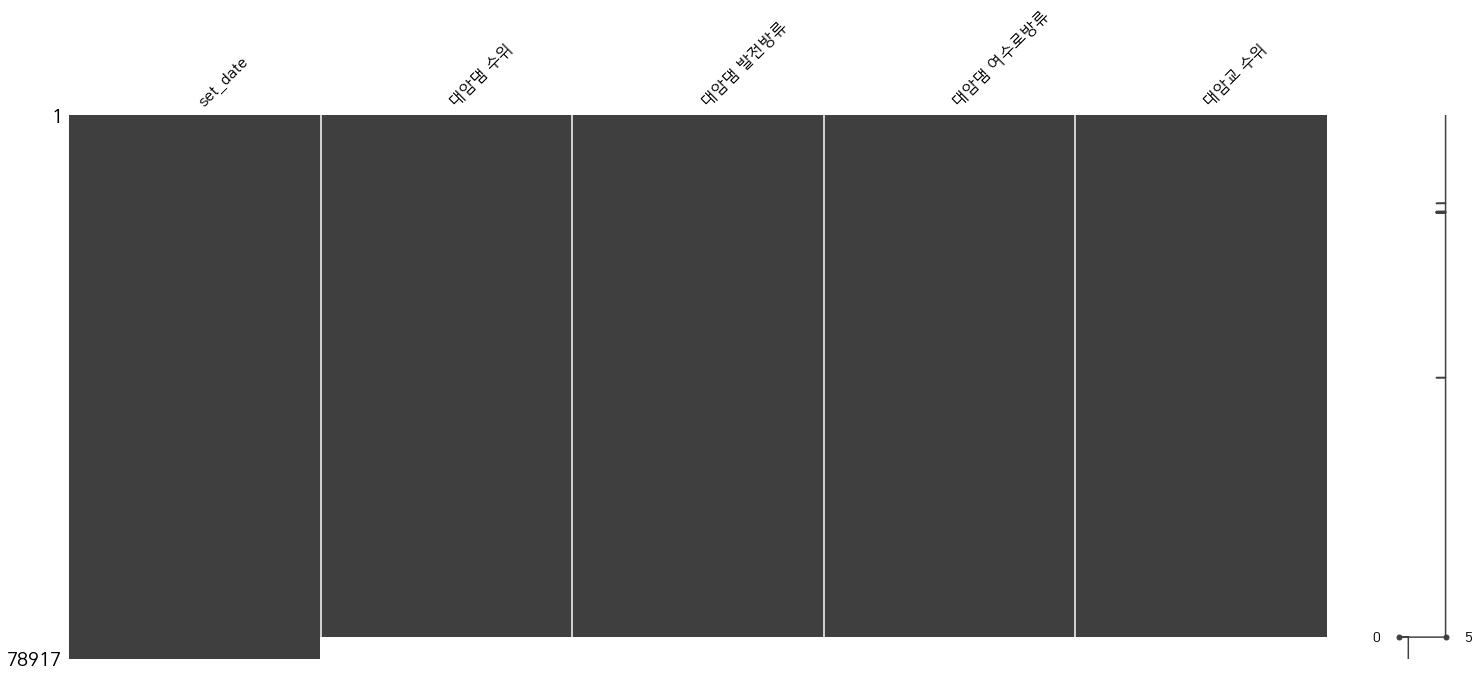

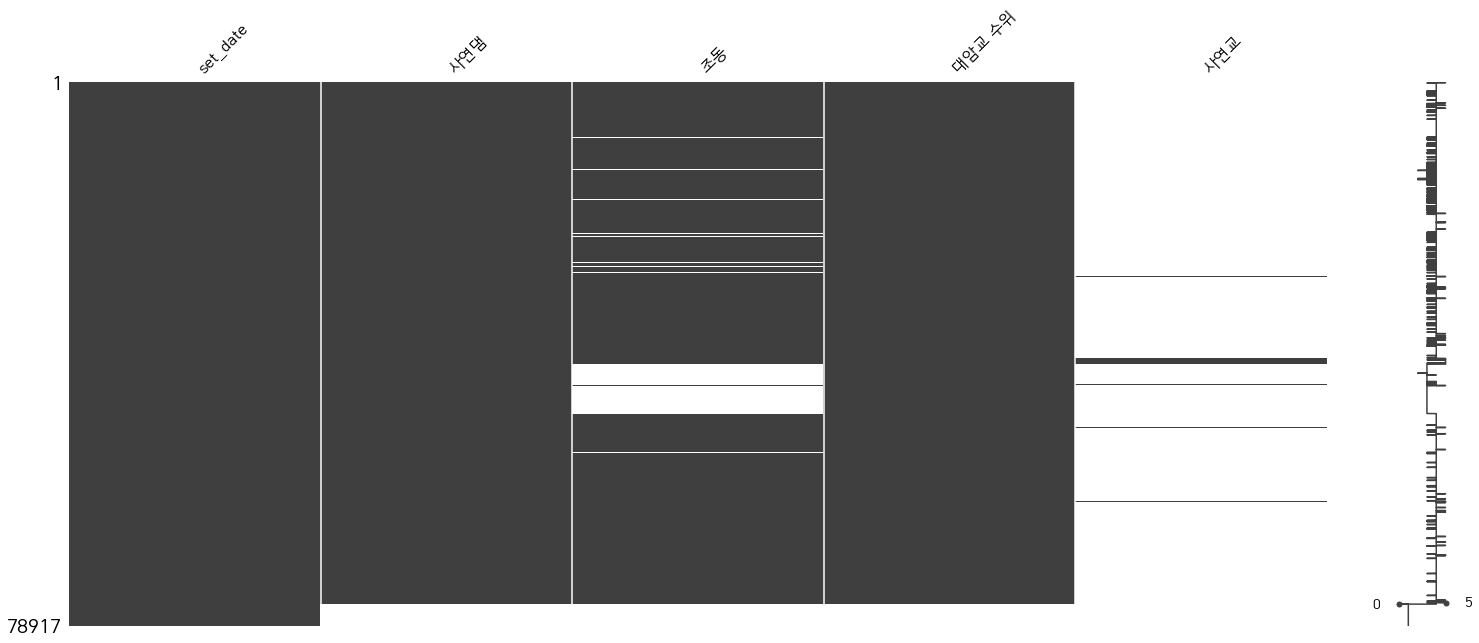

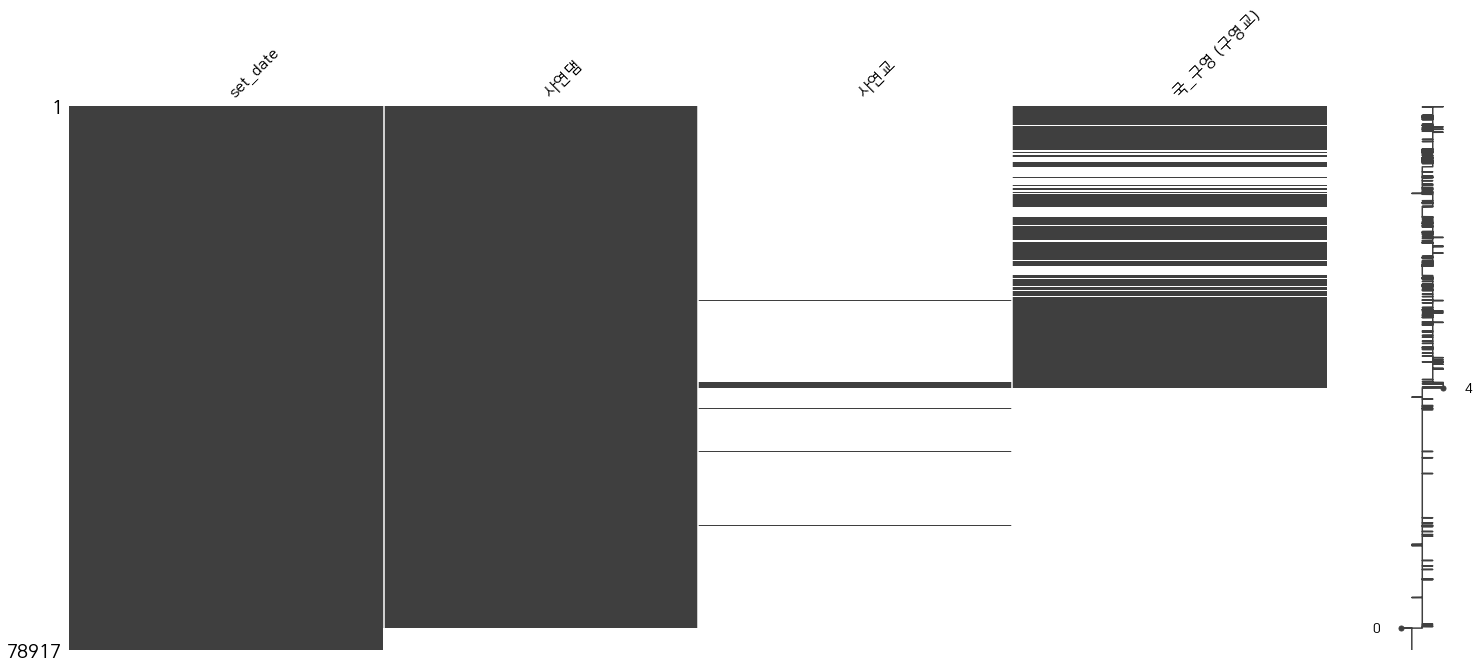

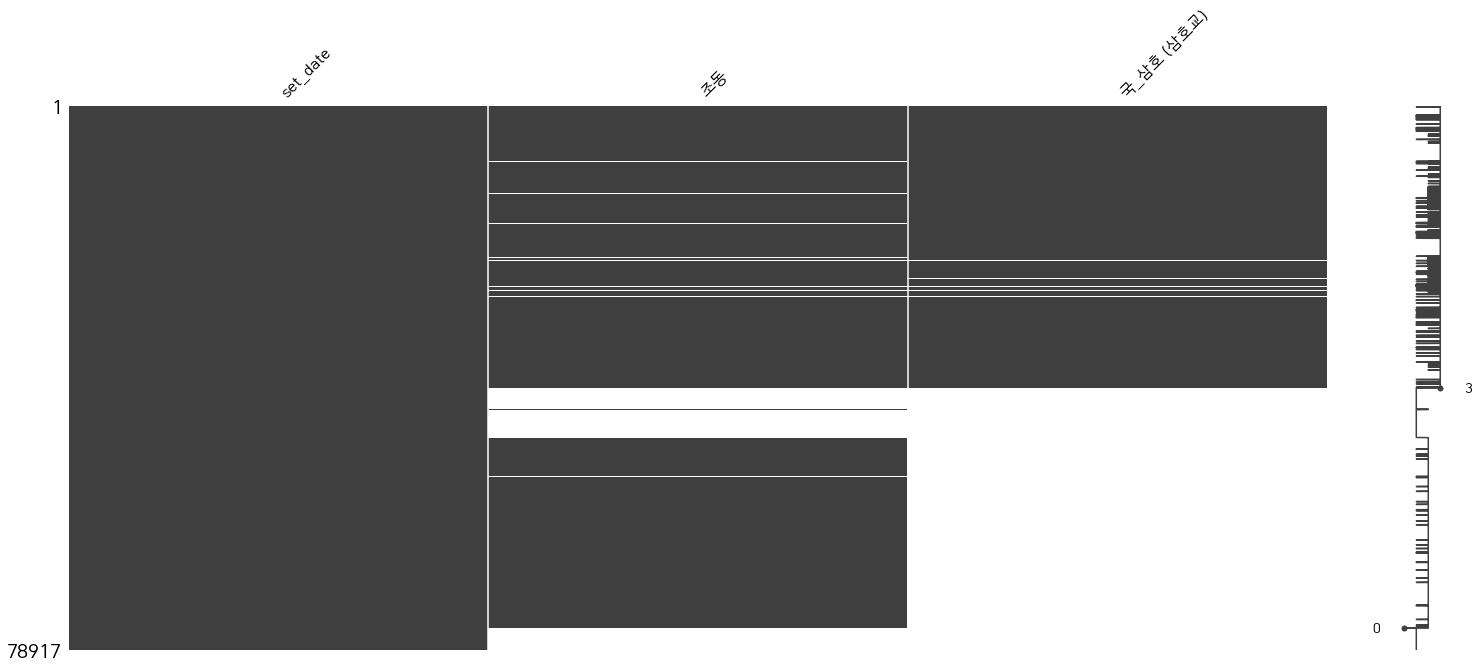

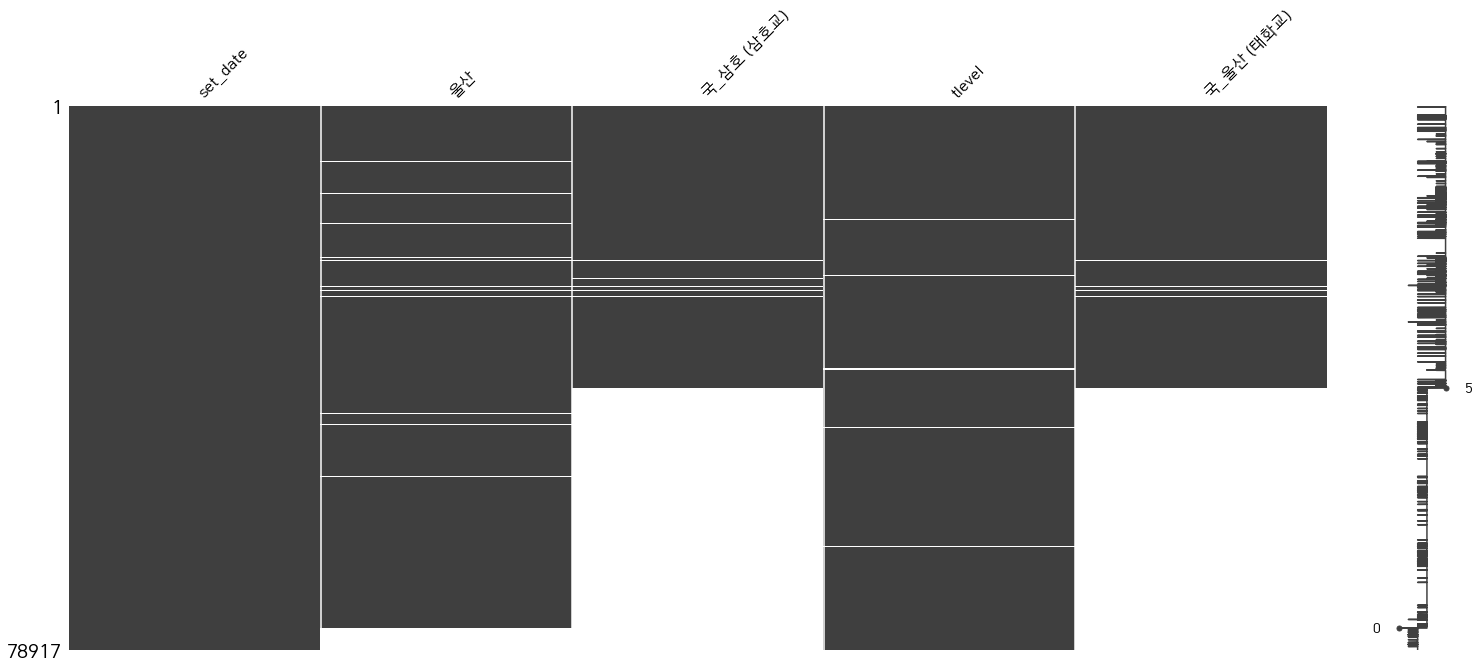

In [9]:
msno.matrix(temp_daeam)
msno.matrix(temp_sayeon)
msno.matrix(temp_guyoung)
msno.matrix(temp_samho)
msno.matrix(temp_taewha)

<h3> 이상 데이터 제거 </h3>

In [10]:
# Error Data Control : Delete & temp set make
temp_daeam = temp_daeam.dropna(how='any')
temp_sayeon = temp_sayeon.dropna(how='any')
temp_guyoung = temp_guyoung.dropna(how='any')
temp_samho = temp_samho.dropna(how='any')
temp_taewha = temp_taewha.dropna(how='any')

<h3> 데이터 확인 </h3>

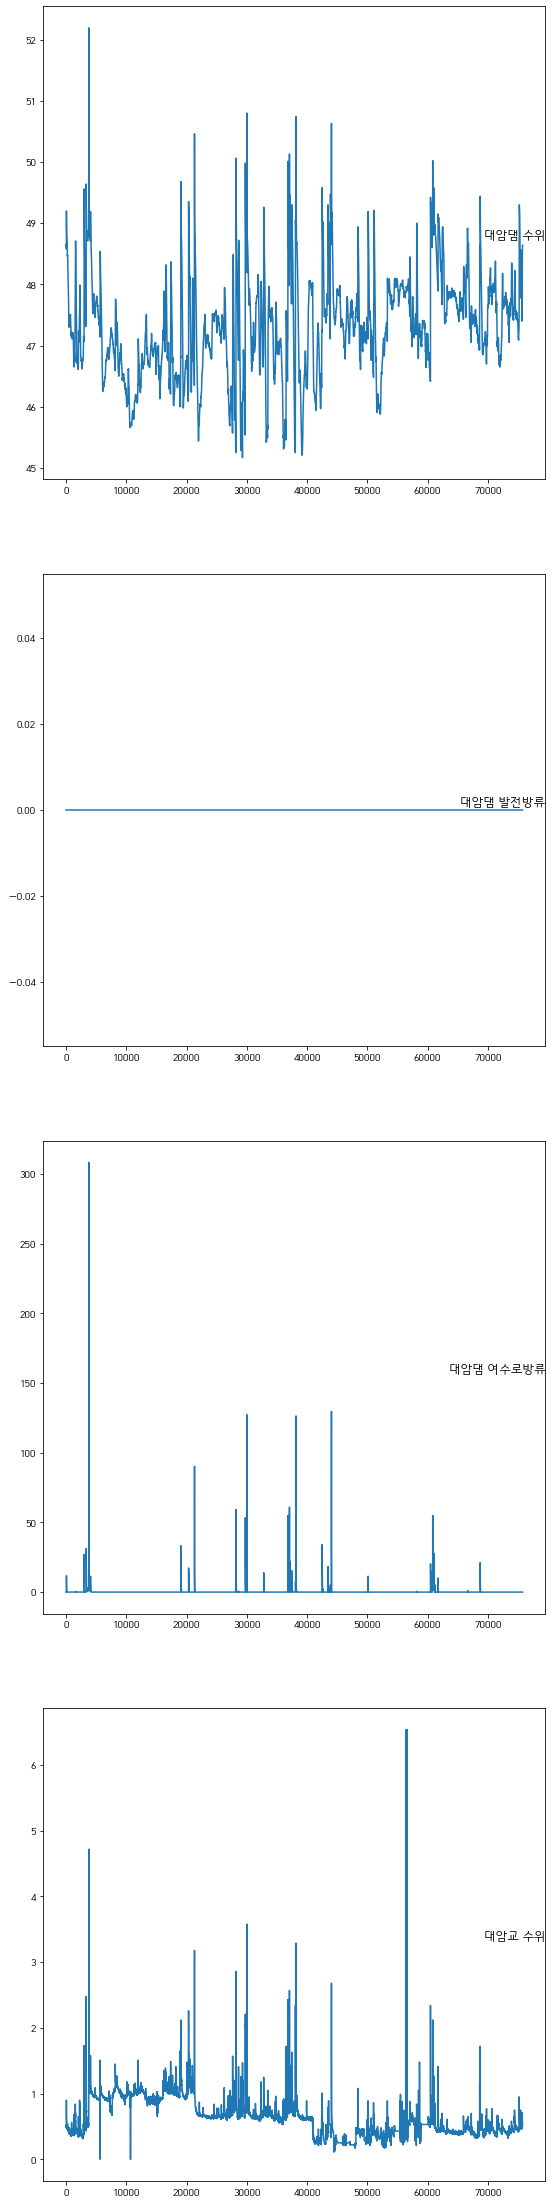

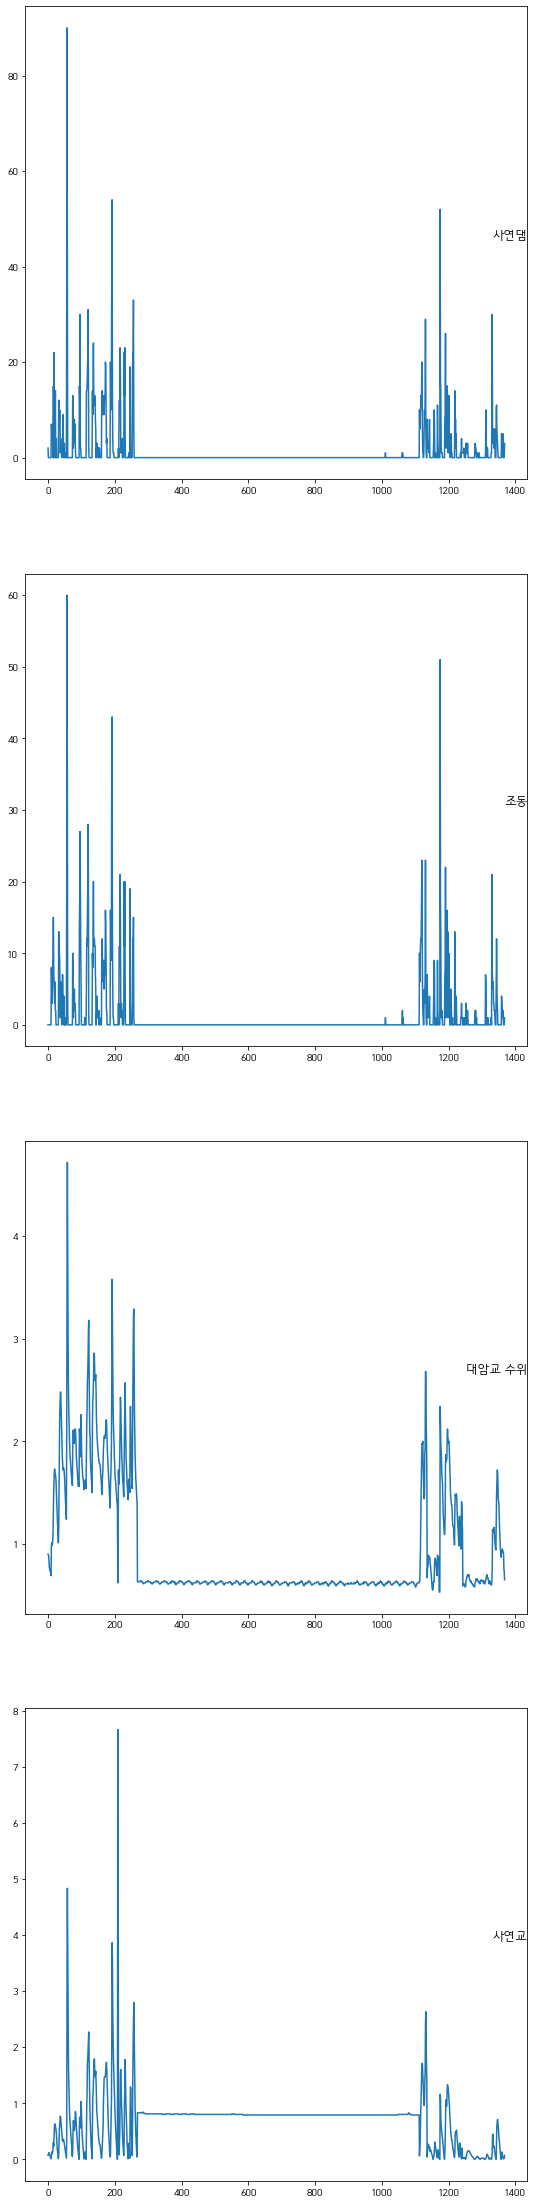

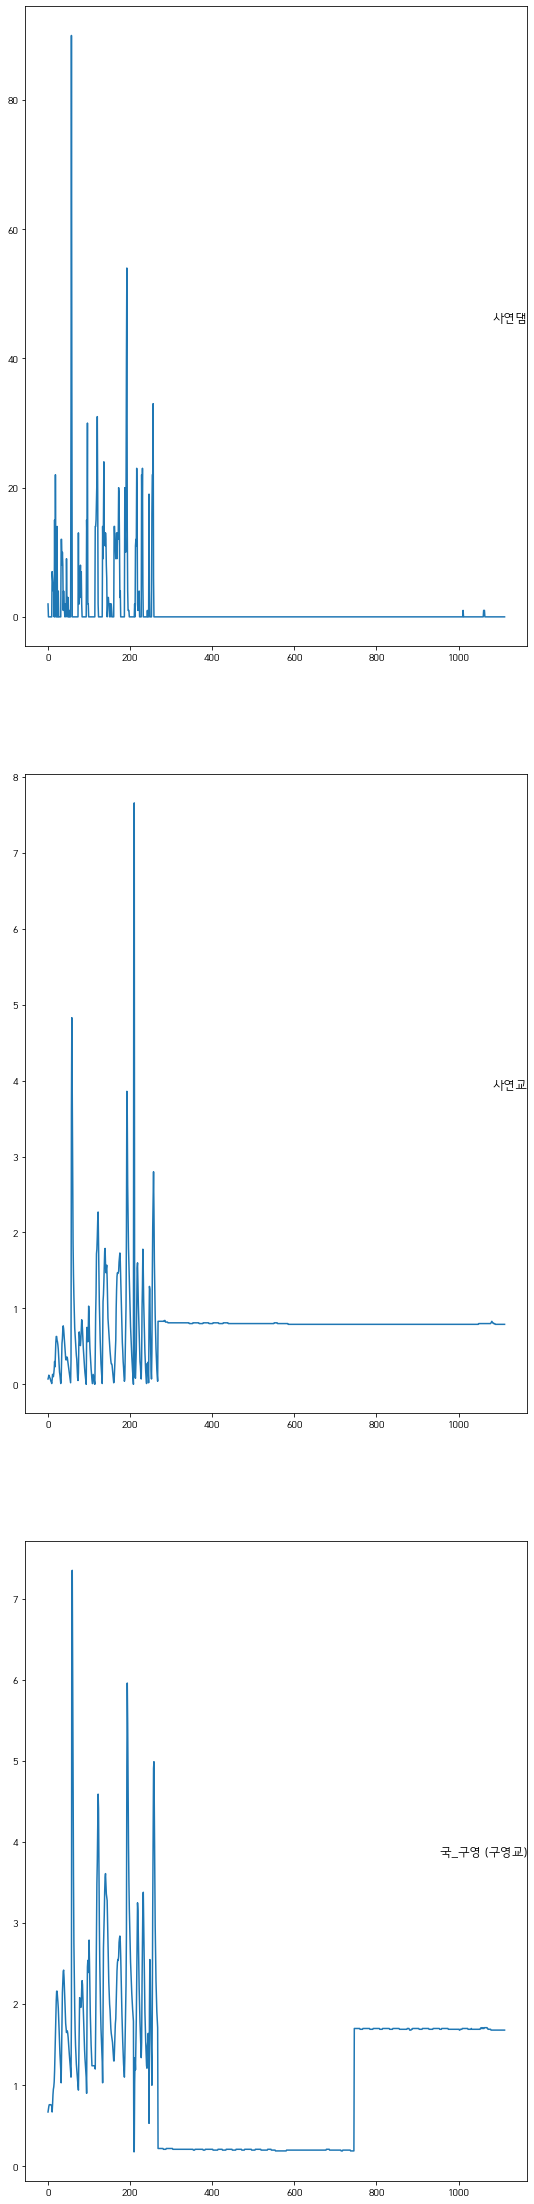

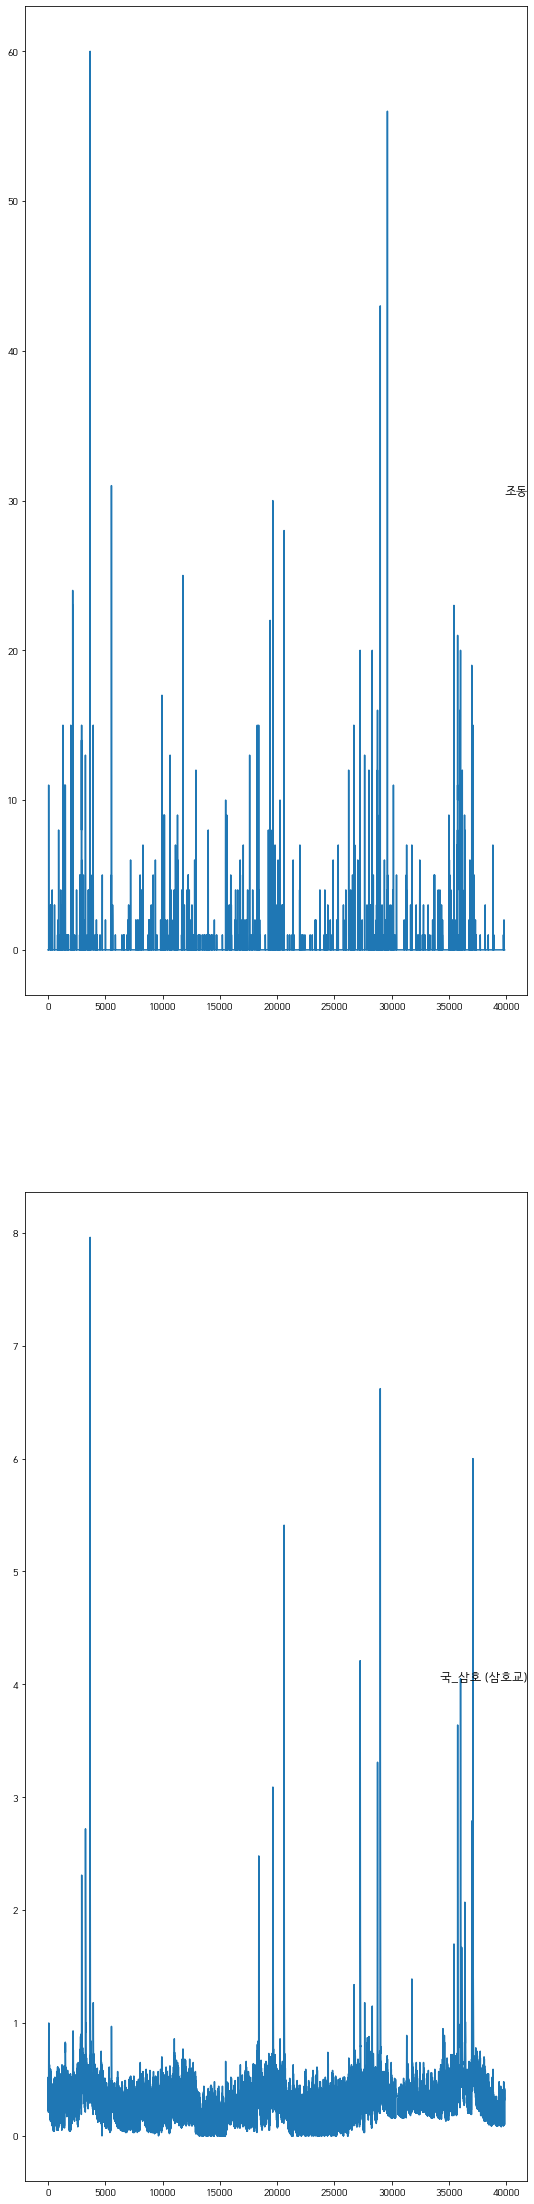

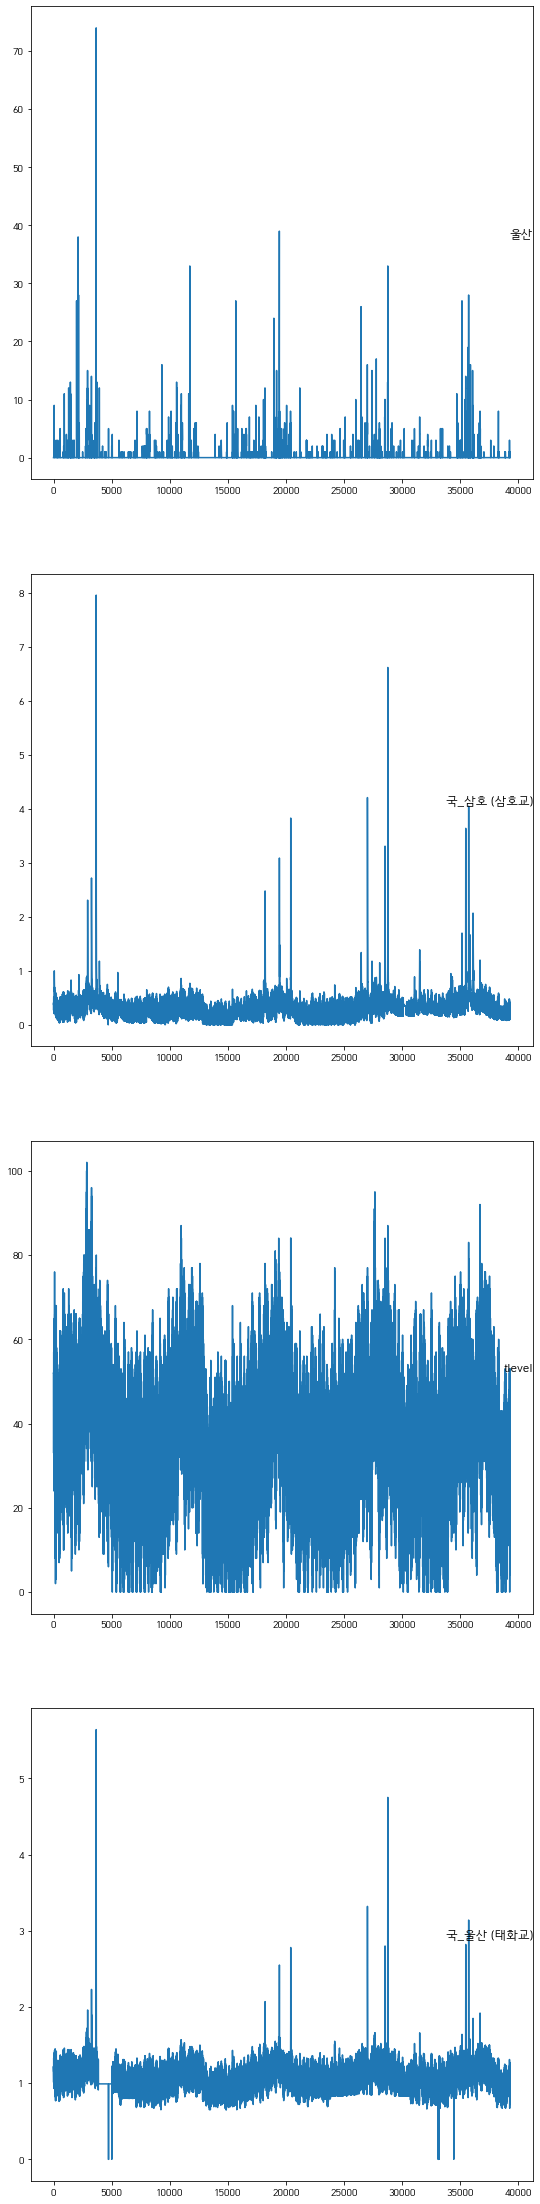

In [11]:
total_chart(temp_daeam, daeam)
total_chart(temp_sayeon, sayeon)
total_chart(temp_guyoung, guyoung)
total_chart(temp_samho, samho)
total_chart(temp_taewha, taewha)

# 데이터 shape 확인
# print(temp_daeam.shape)
# print(temp_sayeon.shape)
# print(temp_guyoung.shape)
# print(temp_samho.shape)
# print(temp_taewha.shape)

# print(temp_daeam.head())
# print(temp_sayeon.head())
# print(temp_guyoung.head())
# print(temp_samho.head())
# print(temp_taewha.head())

<h2> 모델 생성 및 학습 </h2>

model :  GBM
daeam GBM 예측 RMSE :  0.023447648077101556
daeam GBM 예측 R2 :  0.9511638637124117
daeam GBM 예측 MSE :  0.0005497922003476043


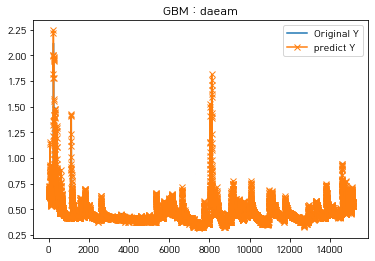

sayeon GBM 예측 RMSE :  1.10058801523935
sayeon GBM 예측 R2 :  -4.788172971924602
sayeon GBM 예측 MSE :  1.2112939792884916


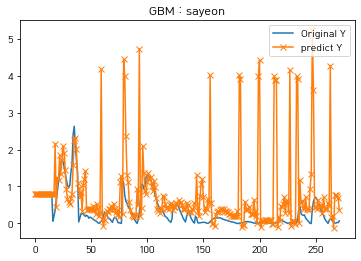

guyoung GBM 예측 RMSE :  0.047395716098699546
guyoung GBM 예측 R2 :  -35.319574632581045
guyoung GBM 예측 MSE :  0.0022463539045085275


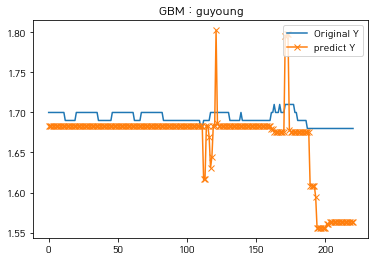

samho GBM 예측 RMSE :  0.10143582812866132
samho GBM 예측 R2 :  0.8915671223716883
samho GBM 예측 MSE :  0.01028922722814732


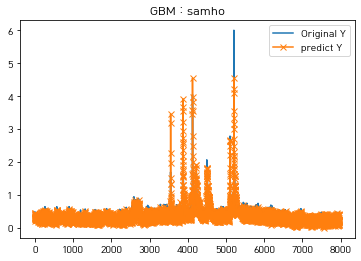

taewha GBM 예측 RMSE :  0.07842892118489075
taewha GBM 예측 R2 :  0.8477489673003841
taewha GBM 예측 MSE :  0.006151095678225806


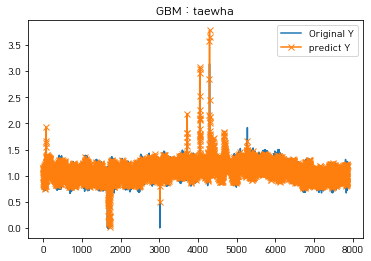

model :  RF
daeam RF 예측 RMSE :  0.04311902414374795
daeam RF 예측 R2 :  0.8348492426633164
daeam RF 예측 MSE :  0.0018592502431091183


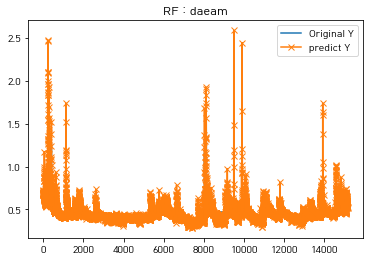

sayeon RF 예측 RMSE :  0.8858792615415553
sayeon RF 예측 R2 :  -2.750084142340741
sayeon RF 예측 MSE :  0.7847820660294114


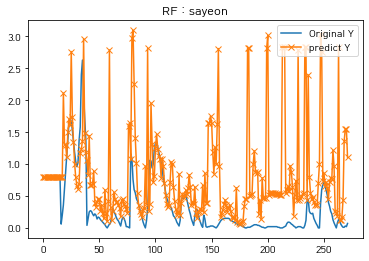

guyoung RF 예측 RMSE :  0.01909523997400998
guyoung RF 예측 R2 :  -4.8953937405421195
guyoung RF 예측 MSE :  0.00036462818966502867


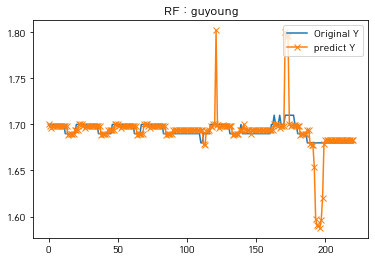

samho RF 예측 RMSE :  0.09831537002519682
samho RF 예측 R2 :  0.8981359213865722
samho RF 예측 MSE :  0.00966591198319137


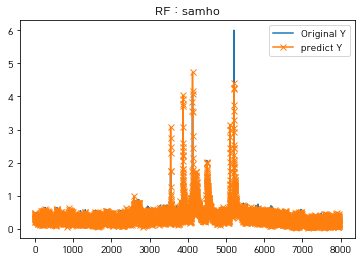

taewha RF 예측 RMSE :  0.07694935939446487
taewha RF 예측 R2 :  0.8534392151467798
taewha RF 예측 MSE :  0.00592120391121852


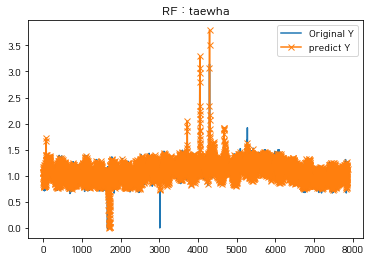

In [12]:
# 태화강 일대
temp_list = [temp_daeam, temp_sayeon, temp_guyoung, temp_samho, temp_taewha]

for md in model_list:
    print("=" * 30)
    print("model : ", md)
    print("=" * 30)
    count = 0
    for df in temp_list:
        """
        Modulation 2 : 학습데이터 정제
        """
        # print("Modulation 2 : 학습데이터 정제")
        # 날짜 데이터를 제외한 나머지 값
        xy = df.drop(['set_date'], axis='columns')

        dataDim = len(xy.columns)  # 매개변수의 개수

        # train셋과 test셋을 분류(0.8 비율)
        trainSize = int(len(xy) * trainSize_rate)
        trainSet = xy[0:trainSize]
        testSet = xy[trainSize - seqLength:]

        """
        Modulation 3 : 모델 학습
        """
        # print("Modulation 3 : 모델 학습")
        if md == "LSTM":
            MinMaxScaler(trainSet)
            MinMaxScaler(testSet)

            # 각 지점의 알맞는 학습 배치 데이터 생성
            trainX, trainY = buildDataSet(trainSet, seqLength, target)
            testX, testY = buildDataSet(testSet, seqLength, target)
            predict = AL_LSTM(trainX, trainY, testX, testY)

            yhat = back_MinMax(xy[xy.columns[-1]], predict)
            actual = back_MinMax(xy[xy.columns[-1]], testY)

        else:
            if md == "GBM":
                # 각 지점의 알맞는 학습 배치 데이터 생성
                trainX, trainY = buildDataSet2(trainSet, seqLength, target)
                testX, testY = buildDataSet2(testSet, seqLength, target)
                predict = AL_GradientBoosting(trainX, trainY, testX, testY)
            elif md == "RF":
                # 각 지점의 알맞는 학습 배치 데이터 생성
                trainX, trainY = buildDataSet2(trainSet, seqLength, target)
                testX, testY = buildDataSet2(testSet, seqLength, target)
                predict = AL_RandomForest(trainX, trainY, testX, testY)

            yhat = predict
            actual = testY

        # 성과지표 표출 부분 : 적용 항목은 confing > performance_list[] 참조
        for pi in performance_list:
            rmse = Performance_index(actual, yhat, pi)
            print(temp_list_name[count] + " " + md + ' 예측 ' + pi + ' : ', rmse)


        """
        Modulation 4 : 결과 데이터 저장
        """
        # print("Modulation 4 : 결과 데이터 저장")

        dir_list = makeDir(md)
        # # 복원된 데이터 저장
        # pd_actual_save = pd.DataFrame(actual)
        # pd_actual_save.to_csv(dir_list['data'][0] + temp_list_name[count] + "_actual", mode='w')
        #
        # pd_predict_save = pd.DataFrame(yhat)
        # pd_predict_save.to_csv(dir_list['data'][0] + temp_list_name[count], mode='w')

        # 그래프 저장
        
        plt.figure()
        plt.title(md + " : " + temp_list_name[count])
        plt.plot(range(len(actual)), actual, '-', label="Original Y")
        plt.plot(range(len(yhat)), yhat, '-x', label="predict Y")
        plt.legend(loc='upper right')
        plt.savefig(dir_list['graph'][0] + temp_list_name[count] + '.png')
        plt.show()

        count += 1

#plt.show()